<a href="https://colab.research.google.com/github/jcandane/Lightfield/blob/main/lightfield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lightfield Class .ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#plt.style.use("dark_background")

π = np.pi
np.set_printoptions(precision=4, linewidth=200, threshold=2000, suppress=True)

In [2]:
def rotation_matrix(θ):
    """
    GIVEN: θ (angle in degrees)
    GET:   R (the 3 rotation matrices)
    """

    θ *= np.pi/180 ## degrees to radians
    R_yz = np.array([[1.,        0.,         0.], 
                     [0., np.cos(θ), -np.sin(θ)], 
                     [0., np.sin(θ), np.cos(θ)]])
    R_xz = np.array([[ np.cos(θ), 0., np.sin(θ)], 
                     [        0., 1.,        0.], 
                     [-np.sin(θ), 0., np.cos(θ)]])
    R_xy = np.array([[np.cos(θ), -np.sin(θ), 0.], 
                     [np.sin(θ),  np.cos(θ), 0.], 
                     [0.       ,         0., 1.]])

    return np.asarray([R_yz, R_xz, R_xy])

class lightfield(object):
    ''' A class of Spatially Homogeneous Light-Field Gaussian Pulses '''
    def __init__(self, k=np.array([1., 0., 0.]), w=1., E0=1e-5, b=0.0, dt=0.01, T=10, Γ=np.inf, t0=0., ϕ=0.):
        π = np.pi
        c = 137.035999206

        self.k  = k   ## unit wave-vector
        self.t0 = t0  ## time delay
        self.w  = w   ## frequency
        self.Γ  = Γ   ## FWHM
        self.b  = b   ## chirp parameter

        self.dt = dt  ## time-step
        self.T  = T   ## duration
        
        self.ϕu = ϕ   ## up   phase
        self.ϕd = ϕ   ## down phase
        self.Eu = E0  ## up   amplitude
        self.Ed = 0.  ## down amplitude

        self.D      = None  ## density-matrix
        self.E_stx  = None  ## real-time E-field
        self.E_sωx  = None  ## frequency E-field
        self.A_stx  = None  ## real-time A-field
        self.A_sωx  = None  ## frequency A-field
        self.B_stx  = None  ## real-time B-field
        self.B_sωx  = None  ## frequency B-field      
        self.F_stuv = None  ## real-time F-field
        self.F_sωuv = None  ## frequency F-field
    
    def fft(self, X):
        return np.sqrt(2*π)/(len(self.t) * self.dω) * np.fft.fftshift( np.fft.fft((X).real , axis=1) )

    def gaussianpulse(self):
        return np.exp( (1j*self.b - 4*np.log(2)/(self.Γ**2) ) * (self.t - self.t0)**2 - 1j * self.w * (self.t - self.t0) )

    def get_E(self, D=None):
        if D is None and self.D is None:
            self.D = np.array([[self.Eu * np.exp(1j*self.ϕu), 0.], [0., self.Ed * np.exp(1j*self.ϕd)]])

        self.t  = np.arange(0., self.T, self.dt)
        self.dω = 2*π / (self.T-self.dt)
        self.Ω  = π / self.dt
        self.ω  = np.arange(-self.Ω, self.Ω+self.dω/2, self.dω)

        basis      = rotation_matrix(90) @ (k/np.linalg.norm(k))
        subbasis   = np.where( np.sum( np.abs( basis - k[None, :] ), axis=1) != 0)[0]
        self.e_sx  = np.array([basis[subbasis[0]], basis[subbasis[1]]]) ## unit ortho. basis vectors
        self.E_stx = self.gaussianpulse()[None, :,None] * (self.D @ self.e_sx)[:,None,:]
        self.E_sωx = self.fft(self.E_stx)
        return np.sum(self.E_stx, axis=0), np.sum(self.E_sωx, axis=0)

    def get_A(self):
        if self.E_sωx is None:
            self.get_E()
        self.A_stx = c/(1j * self.w) * self.E_stx
        self.A_sωx = c/(1j * self.w) * self.E_sωx
        return np.sum(self.A_stx, axis=0), np.sum(self.A_sωx, axis=0)
    
    def get_F(self):
        if self.E_sωx is None:
            self.get_E()
        flip  = np.array([[0.,1.],[1.,0.]])
        self.B_stx = self.gaussianpulse()[None, :,None] * (self.D @ (flip @ self.e_sx))[:,None,:] / c
        self.B_sωx = self.fft(self.B_stx)

        F_stuv     = np.zeros( (2,len(self.t),4,4) , dtype=np.complex128)
        F_stuv[:,:,0,1:4] = self.E_stx
        F_stuv[:,:,1,2] = -self.B_stx[:,:,2]
        F_stuv[:,:,1,3] =  self.B_stx[:,:,1]
        F_stuv[:,:,2,3] =  self.B_stx[:,:,0]
        F_stuv         -= F_stuv.swapaxes(2,3)
        self.F_stuv = F_stuv

        F_sωuv     = np.zeros( (2,len(self.t),4,4) , dtype=np.complex128)
        F_sωuv[:,:,0,1:4] = self.E_sωx
        F_sωuv[:,:,1,2] = -self.B_sωx[:,:,2]
        F_sωuv[:,:,1,3] =  self.B_sωx[:,:,1]
        F_sωuv[:,:,2,3] =  self.B_sωx[:,:,0]
        F_sωuv         -= F_sωuv.swapaxes(2,3)
        self.F_sωuv = F_sωuv
        return np.sum(self.F_stuv, axis=0), np.sum(self.F_sωuv, axis=0)

In [3]:
k = np.array([1.,0.,0.])

#basis    = np.einsum("xyz, z -> xy", rotation_matrix(90), k/np.linalg.norm(k))
basis    = rotation_matrix(90) @ k
print( basis.shape )
subbasis = np.where( np.sum( np.abs( basis - k[None, :] ), axis=1) != 0)[0]
e_sx     = np.array([basis[subbasis[0]], basis[subbasis[1]]])

print( basis )
print( basis[subbasis[0]] )
print( basis[subbasis[1]] )
print( np.allclose(  np.cross( basis[subbasis[0]], basis[subbasis[1]] ) , k/np.linalg.norm(k) ) )
print(e_sx)

e_sx.shape

(3, 3)
[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
[ 0.  0. -1.]
[0. 1. 0.]
True
[[ 0.  0. -1.]
 [ 0.  1.  0.]]


(2, 3)

# Fourier Transforms Domain

## FT: Single Sine Wave

$\sin{\left( 2\pi f t \right)} \rightarrow i\sqrt{\frac{\pi}{2}} \,\delta(\omega - 2\pi f) - i\sqrt{\frac{\pi}{2}} \,\delta(\omega + 2\pi f) $

dω = 0.063


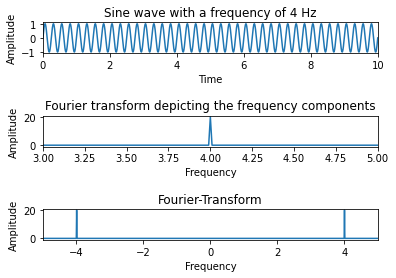

Numerical Integral of Fourier Transform = 1.258047 
Analytic  Integral of Fourier Transform = 1.253314 


In [4]:
Ω  = 30000   ## Sampling Frequency
T  = 100   ## End time period of the signals
dt = π / Ω ## At what intervals time points
dω = 2*π / (T-dt)

# Time & Frequency points
t  = np.arange(0., T, dt)
ω  = np.arange(0., Ω, dω) ## only get positive frequencies, only works with arrays of odd length!!!
ωω = np.arange(-Ω, Ω + dω, dω)

# Create a sine wave
f = 4 # Frequency of the signal 1
X = np.sin(2*π*f*t)

# Create subplot
figure, axis = plt.subplots(3, 1)
plt.subplots_adjust(hspace=2)
# Time domain representation for sine wave 1
axis[0].set_title("Sine wave with a frequency of 4 Hz")
axis[0].plot(t, X)
axis[0].set_xlabel("Time")
axis[0].set_ylabel("Amplitude")
axis[0].set_xlim([0, 10])

# Frequency domain representation
print("dω = %4.3f" % dω)
fourierTransform = np.sqrt(2*π)/(len(X) * dω) * np.fft.fft(X) ## Normalize amplitude
fourierTransform = fourierTransform[range(int(len(X)/2))]     ## get +frequency

# +Frequency domain representation
axis[1].set_title("Fourier transform depicting the frequency components")
axis[1].plot(ω/(2*π), abs(fourierTransform))  ## angular frequencies ω/(2*π) ### for reg freq -> /(2*π)
axis[1].set_xlabel("Frequency")
axis[1].set_ylabel("Amplitude")
axis[1].set_xlim([3, 5])

# Frequency domain representation
axis[2].set_title("Fourier-Transform")
axis[2].plot(ωω/(2*π), np.sqrt(2*π)/(len(X) * dω) * abs( np.fft.fftshift( np.fft.fft(X) )) )  ## angular frequencies ω/(2*π) ### for reg freq -> /(2*π)
axis[2].set_xlabel("Frequency")
axis[2].set_ylabel("Amplitude")
axis[2].set_xlim([-5, 5])
plt.show()

print( "Numerical Integral of Fourier Transform = %4.6f " % ( np.sum( abs(fourierTransform)*dω ) ) )
print( "Analytic  Integral of Fourier Transform = %4.6f " % (np.sqrt(π/2)) )

## FT: Two Sine Waves

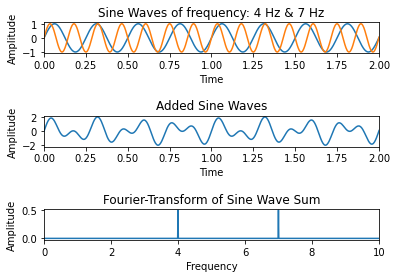

In [5]:
Ω  = 1000   ## Sampling Frequency
T  = 100    ## End time period of the signals
dt = π / Ω ## At what intervals time points
dω = 2*π / (T-dt)

# Time & Frequency points
t = np.arange(0., T, dt)
ω = np.arange(0., Ω, dω) ## only get positive frequencies, only works with arrays of odd length!!!

# Create two sine waves
w1 = 4 # Frequency of the signal 1
w2 = 7 # Frequency of the signal 2
amplitude1 = np.sin(2*π*w1*t)
amplitude2 = np.sin(2*π*w2*t)

# Create subplot
figure, axis = plt.subplots(3, 1)
plt.subplots_adjust(hspace=2.0)
# Time domain representation for sine wave 1
axis[0].set_title("Sine Waves of frequency: 4 Hz & 7 Hz")
axis[0].plot(t, amplitude1)
axis[0].plot(t, amplitude2)
axis[0].set_xlabel("Time")
axis[0].set_ylabel("Amplitude")
axis[0].set_xlim([0, 2])
# Add the sine waves
X = amplitude1 + amplitude2
# Time domain representation of the resultant sine wave
axis[1].set_title("Added Sine Waves")
axis[1].plot(t, X)
axis[1].set_xlabel("Time")
axis[1].set_ylabel("Amplitude")
axis[1].set_xlim([0, 2])

# Frequency domain representation
fourierTransform = np.fft.fft(X)/len(X)           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(X)/2))] # Exclude sampling frequency

# Frequency domain representation
axis[2].set_title("Fourier-Transform of Sine Wave Sum")
axis[2].plot(ω/(2*π), abs(fourierTransform))  ## angular frequencies ω/(2*π) ### for reg freq -> /(2*π)
axis[2].set_xlabel("Frequency")
axis[2].set_ylabel("Amplitude")
axis[2].set_xlim([0, 10])
plt.show()

# Lightfield Without Class

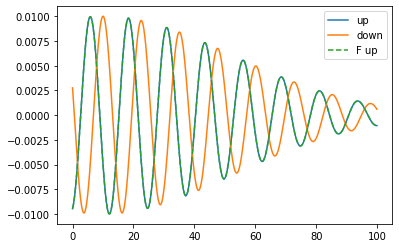

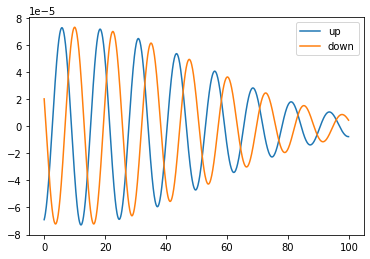

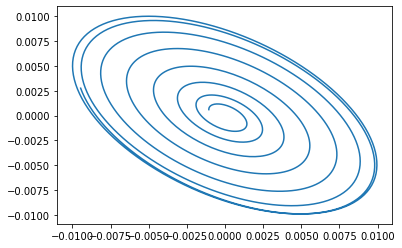

In [6]:
c = 137
π = np.pi

### inputs
w     = 0.5     ## freq of mono. light
Γ     = 100. #np.inf  ## pulse temporal-width
t0    = 10.     ## temporal offset
E_u0  = 1e-2    ##   up-E-field intensity
E_d0  = 1e-2    ## down-E-field intensity
ϕ_u   = np.pi/3 ##   up-phase 
ϕ_d   = 0.      ## down-phase 
k     = np.array([0.,0.,1.]) ## unit wave-vector
dt    = 0.1
T     = 100

t        = np.arange(0, T, dt)
dω       = 2*π / (T-dt)
Ω        = π / dt
ω        = np.arange(-Ω, Ω + dω, dω)
basis    = np.einsum("xyz, z -> xy", rotation_matrix(90), k)
subbasis = np.where( np.sum( np.abs( basis - k[None, :] ), axis=1) != 0)[0]

Eu_t =  E_u0 * np.exp( - 4*np.log(2) * (t - t0)**2/(Γ**2) - 1j * w * (t - t0) + 1j * ϕ_u )[:, None] * basis[None, subbasis[0]]
Bu_t = -E_u0 * np.exp( - 4*np.log(2) * (t - t0)**2/(Γ**2) - 1j * w * (t - t0) + 1j * ϕ_u )[:, None] * basis[None, subbasis[1]] / c
Ed_t =  E_d0 * np.exp( - 4*np.log(2) * (t - t0)**2/(Γ**2) - 1j * w * (t - t0) + 1j * ϕ_d )[:, None] * basis[None, subbasis[1]]
Bd_t = -E_d0 * np.exp( - 4*np.log(2) * (t - t0)**2/(Γ**2) - 1j * w * (t - t0) + 1j * ϕ_d )[:, None] * basis[None, subbasis[0]] / c
Au_t = c * Eu_t / (1j * w)
Ad_t = c * Ed_t / (1j * w)

Fu_t = np.zeros( (len(t), 4,4) , dtype=np.complex128)
Fu_t[:,0,1:4] = -Eu_t
Fu_t[:,1,2]   = -Bu_t[:,2]
Fu_t[:,1,3]   =  Bu_t[:,1]
Fu_t[:,2,3]   = -Bu_t[:,0]
Fu_t += -Fu_t.swapaxes(1,2)

Fd_t = np.zeros( (len(t), 4,4) , dtype=np.complex128)
Fd_t[:,0,1:4] = -Ed_t
Fd_t[:,1,2]   = -Bd_t[:,2]
Fd_t[:,1,3]   =  Bd_t[:,1]
Fd_t[:,2,3]   = -Bd_t[:,0]
Fd_t += -Fd_t.swapaxes(1,2)

A_t = np.asarray([ Au_t, Ad_t ])
E_t = np.asarray([ Eu_t, Ed_t ])
B_t = np.asarray([ Bu_t, Bd_t ])
F_t = np.asarray([ Fu_t, Fd_t ])

plt.plot(t, Eu_t.real[:,1], label="up")
plt.plot(t, Ed_t.real[:,0], label="down")
plt.plot(t, -Fu_t[:,0,2].real, label="F up", linestyle="dashed")
plt.legend()
plt.show()

plt.plot(t, Bu_t.real[:,0], label="up")
plt.plot(t, Bd_t.real[:,1], label="down")
plt.legend()
plt.show()

plt.plot(Eu_t.real[:,1], Ed_t.real[:,0])
plt.show()

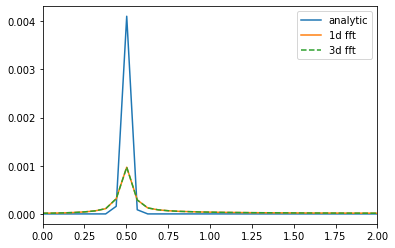

In [7]:
X = Eu_t.real[:,1]
values = np.arange(0, int(len(X)/2), 1)
af =  2 * values * Ω / (len(X))

ft_E_t = Γ * E_u0 * np.exp( - Γ**2 * (w - af)**2/ (16*np.log(2)) + 1j * ( ϕ_u + w*t0) ) / np.sqrt(8*np.log(2))


fft_Eu_3d = np.fft.fft(  Eu_t.real , axis=0 ) / (len(Eu_t) * π)

fft_Eu = (np.fft.fft(  Eu_t.real[:,1]  )) / (len(Eu_t.real[:,1]) * π) ##[:int(len(A_t)/2)]

plt.plot(af, ft_E_t.real/100, label="analytic")
plt.plot(af, np.abs(fft_Eu)[:int(len(X)/2)], label="1d fft")
plt.plot(af, np.abs( fft_Eu_3d[:int(len(X)/2), 1] ), linestyle="dashed", label="3d fft")
plt.xlim([0, 2])
plt.legend()
plt.show()

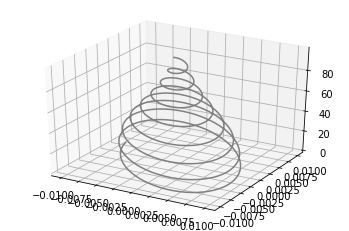

In [8]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = t
xline = Eu_t.real[:,1]
yline = Ed_t.real[:,0]
ax.plot3D(xline, yline, zline, 'gray')
fig.show()

# Lightfield Class

In [9]:
field3    = lightfield()
field3.dt = 0.01
field3.T  = 10.0
field3.E0 = 1e-1
field3.w  = 1
#field3.Γ  = 10.
field3.k = np.array([1.,0.,0.])

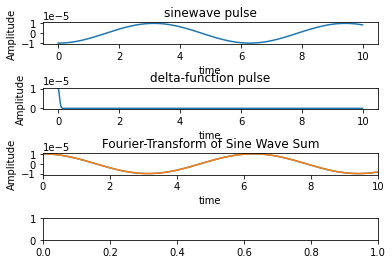

In [10]:
# Create subplot
figure, axis = plt.subplots(4, 1)
plt.subplots_adjust(hspace=2.0)

### Sine Wave
sinewave    = lightfield()
sinewave.dt = 0.01
sinewave.T  = 10.0
sinewave.E0 = 1e-1
sinewave.w  = 1
sinewave.k = np.array([1.,0.,0.])
E_t, E_w = sinewave.get_E()

axis[0].set_title("sinewave pulse")
axis[0].plot(sinewave.t, sinewave.E_stx[0,:,1].real)
axis[0].set_xlabel("time")
axis[0].set_ylabel("Amplitude")

### Delta-Function Pulse
deltafunction    = lightfield()
deltafunction.dt = 0.01
deltafunction.T  = 10.0
deltafunction.E0 = 1e-1
deltafunction.w  = 1
deltafunction.Γ  = 0.1
deltafunction.k  = np.array([1.,0.,0.])
E_t, E_w = deltafunction.get_E()

axis[1].set_title("delta-function pulse")
axis[1].plot(deltafunction.t, -deltafunction.E_stx[0,:,1].real)
axis[1].set_xlabel("time")
axis[1].set_ylabel("Amplitude")

### Gaussian Pulse 1
gaussian1    = lightfield()
gaussian1.dt = 0.01
gaussian1.T  = 10.0
gaussian1.E0 = 1e-1
gaussian1.w  = 1
gaussian1.k = np.array([1.,0.,0.])
E_t, E_w = gaussian1.get_E()

axis[2].set_title("Fourier-Transform of Sine Wave Sum")
axis[2].plot(gaussian1.t, -gaussian1.E_stx[0,:,1].real)
axis[2].set_xlabel("time")
axis[2].set_ylabel("Amplitude")
axis[2].set_xlim([0, 10])

### Gaussian Pulse 2
gaussian2    = lightfield()
gaussian2.dt = 0.01
gaussian2.T  = 10.0
gaussian2.E0 = 1e-1
gaussian2.w  = 1
gaussian2.k = np.array([1.,0.,0.])
E_t, E_w = gaussian2.get_E()

axis[2].set_title("Fourier-Transform of Sine Wave Sum")
axis[2].plot(gaussian2.t, -gaussian2.E_stx[0,:,1].real)
axis[2].set_xlabel("time")
axis[2].set_ylabel("Amplitude")
axis[2].set_xlim([0, 10])

plt.show()

In [11]:
gaussian2.e_sx

array([[ 0., -1.,  0.],
       [ 1.,  0.,  0.]])

In [12]:
!git clone https://github.com/jcandane/pyprototyp
from pyprototyp.pyprototyp import pyprototyp
pyprototyp("lightfield", packages=[], useful=["c = 137.035999206"], defs=[rotation_matrix], classes=[lightfield])

fatal: destination path 'pyprototyp' already exists and is not an empty directory.
